# **Lab 2** - Commit Message Rectification for Bug-Fixing Commits in the Wild

**CS202 - Software Tools and Techniques for CSE**

Bhavya Parmar

23110059

In [1]:
!pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.3 MB/s eta 0:00:00


In [34]:
from pydriller.repository import Repository
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import re
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [3]:
'''
Bug-fixing commit identification using pydriller
'''

bug_fix_commits = pd.DataFrame(columns=['#', 'Message', 'Parent #', 'Merge Commit', 'Modified Files'])

for commit in Repository('https://github.com/Accenture/AmpliGraph.git').traverse_commits():
  res = re.search(r'''\b(((re|)solv(ed|es|e|ing))|(fix(ed|es|ing|s)?)|
  ((bug|error|issue|typo|exception|conflict|problem)(s)?))\b''', commit.msg)

  if res:
    bug_fix_commits.loc[len(bug_fix_commits)] = [commit.hash, commit.msg, commit.parents[0], commit.merge, commit.modified_files]

bug_fix_commits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 0 to 314
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   #               315 non-null    object
 1   Message         315 non-null    object
 2   Parent #        315 non-null    object
 3   Merge Commit    315 non-null    bool  
 4   Modified Files  315 non-null    object
dtypes: bool(1), object(4)
memory usage: 12.6+ KB


In [4]:
bug_fix_commits.describe()

,#,Message,Parent #,Merge Commit,Modified Files
count,315,315,315,315,315
unique,315,243,308,2,243
top,311b614f85942b8b50c8a7e71bedf9aba7382bee,documentation fix,4b9d826cb4ceb1cb2ed98082e20631410307dcb9,False,[]
freq,1,14,3,295,20


In [6]:
bug_fix_commits.head()

,#,Message,Parent #,Merge Commit,Modified Files
0,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,5a2dbf8c312cc6774d24b61a04259b99c82c3365,False,[<pydriller.domain.commit.ModifiedFile object ...
1,a36faa9feafed55dca3d1d0d7341c39c01f1549f,Resolved indentation issue.\n\nIntegration tes...,bd9a60c629d31cb4e24005674c43bbdc6d9ef96c,False,[<pydriller.domain.commit.ModifiedFile object ...
2,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,0a95566bb5dc4e5d81fb02fb06803ed974213302,False,[<pydriller.domain.commit.ModifiedFile object ...
3,a6deac8ea192588a3ef119be08177434986b5963,fixed regularizer syntax error,8c5f964f01b9b7bc141db71789553c4cbbc29498,False,[<pydriller.domain.commit.ModifiedFile object ...
4,c56093ffe7de1333229ffa0696833a4303389f79,"Resolved spelling error, added missing steps a...",a6deac8ea192588a3ef119be08177434986b5963,False,[<pydriller.domain.commit.ModifiedFile object ...


In [ ]:
bug_fix_commits.to_csv('bug_fix_commits.csv', index = False)

In [21]:
'''
Helper Functions
'''

def llm_inference(diff):
    '''
    Using CommitPredictorT5 model to predict fix type in commit
    '''
    tokenizer = AutoTokenizer.from_pretrained("mamiksik/CommitPredictorT5")
    model = AutoModelForSeq2SeqLM.from_pretrained("mamiksik/CommitPredictorT5").to(device) # Move model to device
    
    input_ids = tokenizer(diff, return_tensors="pt").input_ids.to(device) # Move input_ids to device
    
    generated_ids = model.generate(input_ids, max_length=20)
    output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return output


GENERIC_PATTERN = re.compile(r"\b(update|changes?|modify|misc|stuff|minor|necessary|some)\b", re.IGNORECASE)

def need_rect(commit_msg, llm_msg, threshold=7):
    '''
    Decide if rectification is needed.
    Returns:
        * "yes"  - Rectification needed
        * "dev"  - Developer commit msg is apt
        * "llm"  - LLM inference is apt
    '''
    commit_msg_len = len(commit_msg.strip().split()) if commit_msg else 0
    llm_msg_len = len(llm_msg.strip().split()) if llm_msg else 0

    # Rule 1: Empty or too short (<3 words) → rectification
    if commit_msg_len < 3 and llm_msg_len < 3:
        return "yes"

    # Rule 2: Generic dev message → rectification
    if commit_msg and GENERIC_PATTERN.search(commit_msg):
        return "yes"

    # Rule 3: Prefer longer candidate above threshold
    if commit_msg_len >= threshold and commit_msg_len >= llm_msg_len:
        return "dev"
    elif llm_msg_len >= threshold:
        return "llm"

    # Rule 4: Both below threshold → pick longer if decent, else rectify
    if commit_msg_len >= llm_msg_len and commit_msg_len > 3:
        return "dev"
    elif llm_msg_len > 3:
        return "llm"

    return "yes"


def safe_get_source(file):
    try:
        before = file.source_code_before
    except Exception:
        before = None
    try:
        after = file.source_code
    except Exception:
        after = None
    return before, after

In [22]:
!git config --global --add safe.directory '*'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
'''
Diff extraction and analysis
'''
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

diff_analysis = pd.DataFrame(columns=['#', 'Message', 'Filename', 'Source Code (before)',
                                      'Source Code (current)','Diff', 'Fix Type (LLM)',
                                      'Rectified Message'])
# For logging purposes
commit_count = 1

# Hit rates
dev_hit, llm_hit, rect_hit = 0, 0, 0

# Iterate over modified files in bug fixing commits
for _, row in bug_fix_commits.iterrows():
    commit_hash = row['#']
    commit_msg = row['Message']
    modified_files = row['Modified Files']

    print(f"Processing commit {commit_count}")
    
    for file in modified_files:
        
        if file.diff is None or len(file.diff) > 6000:   # skip very large or empty diffs
            llm_output = "SKIPPED"
        else:
            llm_output = llm_inference(file.diff)
            
        code_before, code_after = safe_get_source(file)
        
        if need_rect(commit_msg, llm_output) == "yes":
            rectified_msg = f'''{file.change_type.name} in {file.filename} (+{file.added_lines}, -{file.deleted_lines})\n
            Commit message - {commit_msg}\n
            LLM inference  - {llm_output}'''
            rect_hit += 1
            
        elif need_rect(commit_msg, llm_output) == "dev":
            rectified_msg = "dev"
            dev_hit += 1
            
        else:
            rectified_msg = "llm"
            llm_hit += 1

        diff_analysis.loc[len(diff_analysis)] = [
            commit_hash, commit_msg, file.filename,
            code_before, code_after,file.diff,
            llm_output, rectified_msg
        ]   
    commit_count += 1
    
print("Successfully completed diff_analysis")

Using device: cuda
Processing commit 1
Processing commit 2
Processing commit 3
Processing commit 4


Token indices sequence length is longer than the specified maximum sequence length for this model (1462 > 512). Running this sequence through the model will result in indexing errors


Processing commit 5
Processing commit 6
Processing commit 7
Processing commit 8
Processing commit 9


Token indices sequence length is longer than the specified maximum sequence length for this model (1462 > 512). Running this sequence through the model will result in indexing errors


Processing commit 10
Processing commit 11


Token indices sequence length is longer than the specified maximum sequence length for this model (988 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (678 > 512). Running this sequence through the model will result in indexing errors


Processing commit 12
Processing commit 13


Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors


Processing commit 14
Processing commit 15


Token indices sequence length is longer than the specified maximum sequence length for this model (994 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1193 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (716 > 512). Running this sequence through the model will result in indexing errors


Processing commit 16
Processing commit 17


Token indices sequence length is longer than the specified maximum sequence length for this model (616 > 512). Running this sequence through the model will result in indexing errors


Processing commit 18


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/Comm

Processing commit 19
Processing commit 20


Token indices sequence length is longer than the specified maximum sequence length for this model (1087 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1225 > 512). Running this sequence through the model will result in indexing errors


Processing commit 21
Processing commit 22


Token indices sequence length is longer than the specified maximum sequence length for this model (780 > 512). Running this sequence through the model will result in indexing errors


Processing commit 23


Token indices sequence length is longer than the specified maximum sequence length for this model (1280 > 512). Running this sequence through the model will result in indexing errors


Processing commit 24
Processing commit 25


Token indices sequence length is longer than the specified maximum sequence length for this model (725 > 512). Running this sequence through the model will result in indexing errors


Processing commit 26
Processing commit 27
Processing commit 28
Processing commit 29
Processing commit 30
Processing commit 31
Processing commit 32
Processing commit 33


Token indices sequence length is longer than the specified maximum sequence length for this model (1513 > 512). Running this sequence through the model will result in indexing errors


Processing commit 34
Processing commit 35
Processing commit 36


Token indices sequence length is longer than the specified maximum sequence length for this model (784 > 512). Running this sequence through the model will result in indexing errors


Processing commit 37


Token indices sequence length is longer than the specified maximum sequence length for this model (920 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


Processing commit 38


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/Comm

Processing commit 39


Token indices sequence length is longer than the specified maximum sequence length for this model (1430 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1045 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


Processing commit 40
Processing commit 41
Processing commit 42
Processing commit 43


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


Processing commit 44


Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors


Processing commit 45
Processing commit 46
Processing commit 47
Processing commit 48
Processing commit 49
Processing commit 50
Processing commit 51
Processing commit 52


Token indices sequence length is longer than the specified maximum sequence length for this model (1356 > 512). Running this sequence through the model will result in indexing errors


Processing commit 53


Token indices sequence length is longer than the specified maximum sequence length for this model (1264 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1055 > 512). Running this sequence through the model will result in indexing errors


Processing commit 54


Token indices sequence length is longer than the specified maximum sequence length for this model (1377 > 512). Running this sequence through the model will result in indexing errors


Processing commit 55


Token indices sequence length is longer than the specified maximum sequence length for this model (1108 > 512). Running this sequence through the model will result in indexing errors


Processing commit 56
Processing commit 57
Processing commit 58
Processing commit 59


Token indices sequence length is longer than the specified maximum sequence length for this model (1528 > 512). Running this sequence through the model will result in indexing errors
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


Processing commit 60
Processing commit 61


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/re

Processing commit 62


Token indices sequence length is longer than the specified maximum sequence length for this model (1169 > 512). Running this sequence through the model will result in indexing errors


Processing commit 63
Processing commit 64
Processing commit 65
Processing commit 66
Processing commit 67


Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


Processing commit 68


Token indices sequence length is longer than the specified maximum sequence length for this model (826 > 512). Running this sequence through the model will result in indexing errors


Processing commit 69
Processing commit 70


Token indices sequence length is longer than the specified maximum sequence length for this model (1728 > 512). Running this sequence through the model will result in indexing errors


Processing commit 71


Token indices sequence length is longer than the specified maximum sequence length for this model (1513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1351 > 512). Running this sequence through the model will result in indexing errors


Processing commit 72
Processing commit 73
Processing commit 74


Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors


Processing commit 75


Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


Processing commit 76
Processing commit 77
Processing commit 78
Processing commit 79
Processing commit 80


Token indices sequence length is longer than the specified maximum sequence length for this model (1370 > 512). Running this sequence through the model will result in indexing errors


Processing commit 81
Processing commit 82
Processing commit 83
Processing commit 84
Processing commit 85
Processing commit 86
Processing commit 87


Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1661 > 512). Running this sequence through the model will result in indexing errors


Processing commit 88
Processing commit 89


Token indices sequence length is longer than the specified maximum sequence length for this model (843 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (843 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (909 > 512). Running this sequence through the model will result in indexing errors
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in

Processing commit 90


Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


Processing commit 91
Processing commit 92


Token indices sequence length is longer than the specified maximum sequence length for this model (632 > 512). Running this sequence through the model will result in indexing errors


Processing commit 93
Processing commit 94


Token indices sequence length is longer than the specified maximum sequence length for this model (1682 > 512). Running this sequence through the model will result in indexing errors


Processing commit 95
Processing commit 96


Token indices sequence length is longer than the specified maximum sequence length for this model (1746 > 512). Running this sequence through the model will result in indexing errors


Processing commit 97
Processing commit 98
Processing commit 99
Processing commit 100


Token indices sequence length is longer than the specified maximum sequence length for this model (791 > 512). Running this sequence through the model will result in indexing errors


Processing commit 101


Token indices sequence length is longer than the specified maximum sequence length for this model (803 > 512). Running this sequence through the model will result in indexing errors


Processing commit 102


Token indices sequence length is longer than the specified maximum sequence length for this model (845 > 512). Running this sequence through the model will result in indexing errors


Processing commit 103


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


Processing commit 104


Token indices sequence length is longer than the specified maximum sequence length for this model (927 > 512). Running this sequence through the model will result in indexing errors


Processing commit 105
Processing commit 106
Processing commit 107


Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1370 > 512). Running this sequence through the model will result in indexing errors


Processing commit 108
Processing commit 109


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 1s [

Processing commit 110
Processing commit 111


Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


Processing commit 112


Token indices sequence length is longer than the specified maximum sequence length for this model (910 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1002 > 512). Running this sequence through the model will result in indexing errors


Processing commit 113
Processing commit 114
Processing commit 115


Token indices sequence length is longer than the specified maximum sequence length for this model (709 > 512). Running this sequence through the model will result in indexing errors


Processing commit 116


Token indices sequence length is longer than the specified maximum sequence length for this model (1071 > 512). Running this sequence through the model will result in indexing errors


Processing commit 117


Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


Processing commit 118
Processing commit 119
Processing commit 120
Processing commit 121
Processing commit 122
Processing commit 123
Processing commit 124
Processing commit 125
Processing commit 126
Processing commit 127


Token indices sequence length is longer than the specified maximum sequence length for this model (1013 > 512). Running this sequence through the model will result in indexing errors


Processing commit 128


Token indices sequence length is longer than the specified maximum sequence length for this model (920 > 512). Running this sequence through the model will result in indexing errors


Processing commit 129


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


Processing commit 130


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/re

Processing commit 131
Processing commit 132
Processing commit 133
Processing commit 134
Processing commit 135


Token indices sequence length is longer than the specified maximum sequence length for this model (1178 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (813 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (877 > 512). Running this sequence through the model will result in indexing errors


Processing commit 136
Processing commit 137


Token indices sequence length is longer than the specified maximum sequence length for this model (738 > 512). Running this sequence through the model will result in indexing errors


Processing commit 138


Token indices sequence length is longer than the specified maximum sequence length for this model (1505 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (944 > 512). Running this sequence through the model will result in indexing errors


Processing commit 139
Processing commit 140
Processing commit 141
Processing commit 142


Token indices sequence length is longer than the specified maximum sequence length for this model (1598 > 512). Running this sequence through the model will result in indexing errors


Processing commit 143


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/mamiksik/CommitPredictorT5/2ff105326e69e24e8980ce46997268252b715846/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/mamiksik/CommitPredictorT5/2ff105326e69e24e8980ce46997268252b715846/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/mamiksik/CommitPredictorT5/2ff105326e69e24e8980ce46997268252b715846/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/mamiksik/CommitPredictorT5/2ff105326e69e24e8980ce46997268252b715846/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/mamiksik/CommitPredictorT5/2ff105326e69e24e8980ce46997268252b715846/config.json
Retrying in 8s [Retry 5/5].


Processing commit 144


Token indices sequence length is longer than the specified maximum sequence length for this model (633 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (738 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1055 > 512). Running this sequence through the model will result in indexing errors


Processing commit 145
Processing commit 146


Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


Processing commit 147
Processing commit 148
Processing commit 149
Processing commit 150
Processing commit 151


Token indices sequence length is longer than the specified maximum sequence length for this model (1412 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (898 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1442 > 512). Running this sequence through the model will result in indexing errors


Processing commit 152


Token indices sequence length is longer than the specified maximum sequence length for this model (708 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (672 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1305 > 512). Running this sequence through the model will result in indexing errors


Processing commit 153


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPred

Processing commit 154


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (959 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1328 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (930 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Processing commit 155


Token indices sequence length is longer than the specified maximum sequence length for this model (786 > 512). Running this sequence through the model will result in indexing errors


Processing commit 156
Processing commit 157


Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (919 > 512). Running this sequence through the model will result in indexing errors
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredicto

Processing commit 158


Token indices sequence length is longer than the specified maximum sequence length for this model (761 > 512). Running this sequence through the model will result in indexing errors


Processing commit 159


Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (963 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors


Processing commit 160
Processing commit 161


Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (667 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1120 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


Processing commit 162
Processing commit 163


Token indices sequence length is longer than the specified maximum sequence length for this model (697 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1619 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (861 > 512). Running this sequence through the model will result in indexing errors


Processing commit 164


Token indices sequence length is longer than the specified maximum sequence length for this model (1243 > 512). Running this sequence through the model will result in indexing errors


Processing commit 165
Processing commit 166


Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


Processing commit 167


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/refs%2Fpr%2F1/model.safetensors
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/refs%2Fpr%2F1/model.safetensors
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/refs%2Fpr%2F1/model.safetensors
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting H

Processing commit 168
Processing commit 169
Processing commit 170
Processing commit 171
Processing commit 172


Token indices sequence length is longer than the specified maximum sequence length for this model (1542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (988 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1138 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Processing commit 173
Processing commit 174


Token indices sequence length is longer than the specified maximum sequence length for this model (805 > 512). Running this sequence through the model will result in indexing errors


Processing commit 175


Token indices sequence length is longer than the specified maximum sequence length for this model (855 > 512). Running this sequence through the model will result in indexing errors


Processing commit 176
Processing commit 177


Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


Processing commit 178
Processing commit 179
Processing commit 180
Processing commit 181


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 1s [

Processing commit 182


Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors


Processing commit 183
Processing commit 184


Token indices sequence length is longer than the specified maximum sequence length for this model (1395 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1286 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1903 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1148 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1960 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Processing commit 185


Token indices sequence length is longer than the specified maximum sequence length for this model (1237 > 512). Running this sequence through the model will result in indexing errors
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requ

Processing commit 186


Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors


Processing commit 187


Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


Processing commit 188


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/custom_generate/generate.py
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/custom_generate/generate.py
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/custom_generate/generate.py
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/custom_generate/generate.py
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/custom_generate/generate.py
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/custom_generate/generate.py
HTTP Error 429 thrown while requesting HEAD https:

Processing commit 189


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
Token indices sequence length is longer than the specified maximum sequence length for this model (1661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token i

Processing commit 190


Token indices sequence length is longer than the specified maximum sequence length for this model (1457 > 512). Running this sequence through the model will result in indexing errors


Processing commit 191


Token indices sequence length is longer than the specified maximum sequence length for this model (724 > 512). Running this sequence through the model will result in indexing errors


Processing commit 192


Token indices sequence length is longer than the specified maximum sequence length for this model (891 > 512). Running this sequence through the model will result in indexing errors


Processing commit 193
Processing commit 194
Processing commit 195


Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors


Processing commit 196


Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors


Processing commit 197


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPred

Processing commit 198


Token indices sequence length is longer than the specified maximum sequence length for this model (1416 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1130 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (883 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (865 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (924 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Processing commit 199


Token indices sequence length is longer than the specified maximum sequence length for this model (1319 > 512). Running this sequence through the model will result in indexing errors


Processing commit 200
Processing commit 201
Processing commit 202
Processing commit 203


Token indices sequence length is longer than the specified maximum sequence length for this model (1255 > 512). Running this sequence through the model will result in indexing errors


Processing commit 204
Processing commit 205


Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors


Processing commit 206
Processing commit 207


Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


Processing commit 208


Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


Processing commit 209
Processing commit 210


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/re

Processing commit 211


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


Processing commit 212


Token indices sequence length is longer than the specified maximum sequence length for this model (980 > 512). Running this sequence through the model will result in indexing errors


Processing commit 213
Processing commit 214


Token indices sequence length is longer than the specified maximum sequence length for this model (1147 > 512). Running this sequence through the model will result in indexing errors


Processing commit 215
Processing commit 216
Processing commit 217
Processing commit 218
Processing commit 219
Processing commit 220


Token indices sequence length is longer than the specified maximum sequence length for this model (1176 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1057 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors


Processing commit 221
Processing commit 222
Processing commit 223
Processing commit 224
Processing commit 225
Processing commit 226
Processing commit 227
Processing commit 228


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 1s [

Processing commit 229
Processing commit 230
Processing commit 231
Processing commit 232
Processing commit 233


Token indices sequence length is longer than the specified maximum sequence length for this model (1416 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1130 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (883 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (865 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (924 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Processing commit 234


Token indices sequence length is longer than the specified maximum sequence length for this model (1319 > 512). Running this sequence through the model will result in indexing errors


Processing commit 235
Processing commit 236
Processing commit 237
Processing commit 238


Token indices sequence length is longer than the specified maximum sequence length for this model (1255 > 512). Running this sequence through the model will result in indexing errors


Processing commit 239
Processing commit 240


Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while reque

Processing commit 241
Processing commit 242


Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


Processing commit 243


Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


Processing commit 244
Processing commit 245
Processing commit 246


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


Processing commit 247


Token indices sequence length is longer than the specified maximum sequence length for this model (980 > 512). Running this sequence through the model will result in indexing errors


Processing commit 248
Processing commit 249


Token indices sequence length is longer than the specified maximum sequence length for this model (1147 > 512). Running this sequence through the model will result in indexing errors


Processing commit 250
Processing commit 251
Processing commit 252
Processing commit 253
Processing commit 254
Processing commit 255


Token indices sequence length is longer than the specified maximum sequence length for this model (1176 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1057 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors


Processing commit 256
Processing commit 257


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPred

Processing commit 258
Processing commit 259
Processing commit 260
Processing commit 261
Processing commit 262
Processing commit 263
Processing commit 264


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/tokenizer_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPred

Processing commit 265


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/refs%2Fpr%2F1/model.safetensors.index.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/refs%2Fpr%2F1/model.safetensors.index.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/refs%2Fpr%2F1/model.safetensors.index.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 4s [Retry 3/5].
HTTP Er

Processing commit 266
Processing commit 267
Processing commit 268
Processing commit 269
Processing commit 270
Processing commit 271
Processing commit 272
Processing commit 273
Processing commit 274


Token indices sequence length is longer than the specified maximum sequence length for this model (900 > 512). Running this sequence through the model will result in indexing errors


Processing commit 275
Processing commit 276


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


Processing commit 277
Processing commit 278
Processing commit 279
Processing commit 280
Processing commit 281
Processing commit 282
Processing commit 283
Processing commit 284
Processing commit 285
Processing commit 286
Processing commit 287


Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors


Processing commit 288


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/refs%2Fpr%2F1/model.safetensors.index.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/refs%2Fpr%2F1/model.safetensors.index.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/refs%2Fpr%2F1/model.safetensors.index.json
Retrying in 4s [Retry 3/5].
HTTP Er

Processing commit 289
Processing commit 290


Token indices sequence length is longer than the specified maximum sequence length for this model (739 > 512). Running this sequence through the model will result in indexing errors


Processing commit 291
Processing commit 292
Processing commit 293
Processing commit 294


Token indices sequence length is longer than the specified maximum sequence length for this model (674 > 512). Running this sequence through the model will result in indexing errors


Processing commit 295
Processing commit 296


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


Processing commit 297
Processing commit 298
Processing commit 299
Processing commit 300
Processing commit 301
Processing commit 302


Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors


Processing commit 303
Processing commit 304
Processing commit 305


Token indices sequence length is longer than the specified maximum sequence length for this model (739 > 512). Running this sequence through the model will result in indexing errors


Processing commit 306
Processing commit 307
Processing commit 308
Processing commit 309


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/mamiksik/CommitPredictorT5/resolve/main/generation_config.json
Retrying in 1s [

Processing commit 310
Processing commit 311


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


Processing commit 312
Processing commit 313
Processing commit 314
Processing commit 315
Successfully completed diff_analysis


In [28]:
diff_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 0 to 1094
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   #                      1095 non-null   object
 1   Message                1095 non-null   object
 2   Filename               1095 non-null   object
 3   Source Code (before)   0 non-null      object
 4   Source Code (current)  0 non-null      object
 5   Diff                   1095 non-null   object
 6   Fix Type (LLM)         1095 non-null   object
 7   Rectified Message      1095 non-null   object
dtypes: object(8)
memory usage: 77.0+ KB


In [29]:
diff_analysis.describe()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message
count,1095,1095,1095,0,0,1095,1095,1095
unique,295,224,229,0,0,823,452,327
top,f5c9941e4a38b6c83e7f009343addfb336e70587,docs fix,__init__.py,NaN,NaN,"@@ -1,6 +0,0 @@\n-load_from_rdf\n-============...",SKIPPED,dev
freq,116,232,46,NaN,NaN,4,174,359


In [30]:
diff_analysis.head()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message
0,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,protocol.py,None,None,"@@ -444,6 +444,9 @@ def evaluate_performance(X...",add end_evaluation to performance_test.py,dev
1,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,models.py,None,None,"@@ -4,7 +4,7 @@ from sklearn.utils import chec...",SKIPPED,dev
2,a36faa9feafed55dca3d1d0d7341c39c01f1549f,Resolved indentation issue.\n\nIntegration tes...,models.py,None,None,"@@ -303,17 +303,12 @@ class EmbeddingModel(abc...",add support for negative matrix in tf embeddings,dev
3,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,bug_report.md,None,None,"@@ -0,0 +1,16 @@\n+---\n+name: Bug report\n+ab...",add missing description to reportnofilter,llm
4,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,feature_request.md,None,None,"@@ -0,0 +1,12 @@\n+---\n+name: Feature request...",add missing missing tag,llm


In [42]:
diff_analysis[~diff_analysis["Rectified Message"].isin(["dev", "llm"])].head()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message
22,beadb5db319960ddcdcd246f4fb19e949cc465da,resolved indentation error.,protocol.py,None,None,"@@ -192,7 +192,7 @@ def generate_corruptions_f...",update tf_train_glue.py,"MODIFY in protocol.py (+1, -1)\n\n ..."
46,e7b496d7e266afebaa46b2e36bd6c2ddee565feb,fixed table,ampligraph.datasets.rst,None,None,"@@ -28,7 +28,7 @@ Use these helpers functions ...",add missing line,"MODIFY in ampligraph.datasets.rst (+1, -1)\n\n..."
48,13cd29bd8aa26bbc82a270d27e3b86f918cd30e3,Fixed #51 - Updated random baseline model and ...,models.py,None,None,"@@ -710,7 +710,8 @@ class EmbeddingModel(abc.A...",add transe and t5 models,"MODIFY in models.py (+46, -8)\n\n C..."
52,eca4fe64602c95f0fb569b0a9147641c8cfeb926,minor: fixed examples,metrics.py,None,None,"@@ -170,6 +170,7 @@ def rank_score(y_true, y_p...",update example for rank_score,"MODIFY in metrics.py (+1, -0)\n\n C..."
53,eca4fe64602c95f0fb569b0a9147641c8cfeb926,minor: fixed examples,protocol.py,None,None,"@@ -213,13 +213,12 @@ def generate_corruptions...",add missing docstring,"MODIFY in protocol.py (+4, -5)\n\n ..."


In [27]:
diff_analysis.to_csv('diff_analysis.csv', index = False)

In [43]:
'''
Evaluation
'''

hit_data = pd.DataFrame({
    "Category": ["Developer", "LLM", "Rectifier"],
    "Hits": [dev_hit, llm_hit, rect_hit]
})

total = hit_data["Hits"].sum()
hit_data["Percentage"] = (hit_data["Hits"] / total * 100).round(2)

hit_data

,Category,Hits,Percentage
0,Developer,359,32.79
1,LLM,286,26.12
2,Rectifier,450,41.10


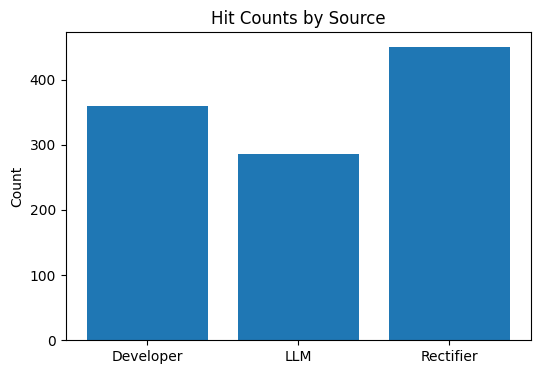

In [35]:
plt.figure(figsize=(6,4))
plt.bar(hit_data["Category"], hit_data["Hits"])
plt.title("Hit Counts by Source")
plt.ylabel("Count")
plt.show()

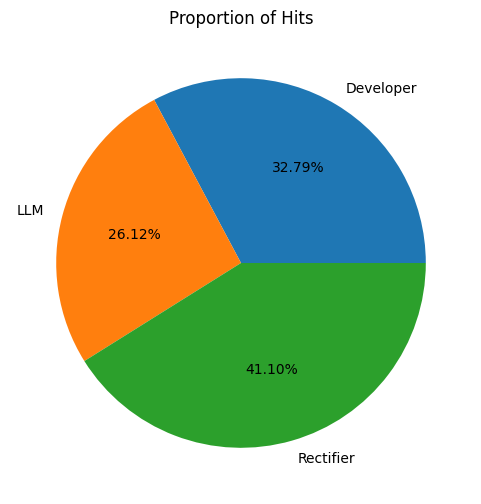

In [37]:
plt.figure(figsize=(6,6))
plt.pie(hit_data["Hits"], labels=hit_data["Category"], autopct='%1.2f%%')
plt.title("Proportion of Hits")
plt.show()